## Bayesian Optimisation Verification

In [2]:
# import relevant packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_squared_error
from itertools import product

# stop showing warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
### Impot data for training and evaluation
# import data sheet (time:0~5000s) with temp 120, 140, 160, 180
address = 'data/degradation.xlsx'
y_normal = np.empty(shape=[0,1])
i = 3
list_temp = (120,140,160,180)
for temp in list_temp:
    df = pd.read_excel(address,sheet_name = 'normal data',usecols = [i],names = None,nrows = 5000)
    df = df.values.tolist()
    df = np.array(df)
    y_normal =  np.append(y_normal,df)
    i+=1

In [4]:
### Data setup 
NUM_OF_DATA_POINTS = 20
NUM_OF_PLOT_POINTS = 100
# gp settings 
NOISE_LEVEL = 1e-5

kernel = 1.0 * RBF(length_scale=5) + WhiteKernel(noise_level=NOISE_LEVEL)

gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-8)

In [5]:
X_ = np.arange(0,5000).astype(int)
x_normal = np.empty(shape=[0,2])
temp_list = np.array([120,140,160,180])

for temp in temp_list:
    df_temp = np.full((5000,1),temp)
    x_normal_partial = np.hstack([X_.reshape(5000,1),df_temp])
    x_normal =  np.concatenate([x_normal,x_normal_partial])

Y = y_normal[np.linspace(0,19999,num=int(4*NUM_OF_DATA_POINTS),dtype=int)]
X = np.empty(shape=[0,2])
X_num = np.linspace(0,4999,num=int(NUM_OF_DATA_POINTS),dtype=int)
for temp in temp_list:
    df_temp = np.full((int(NUM_OF_DATA_POINTS),1),temp)
    X_partial = np.hstack([X_num.reshape(int(NUM_OF_DATA_POINTS),1),df_temp])
    X = np.concatenate([X, X_partial])

#### Kernel setting and prediction

gp.fit(X, Y)
print("Learned kernel", gp.kernel_)


Learned kernel 316**2 * RBF(length_scale=4.95e+03) + WhiteKernel(noise_level=1e-05)


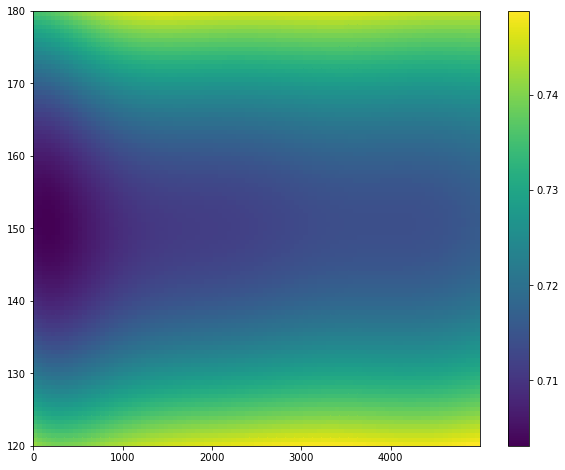

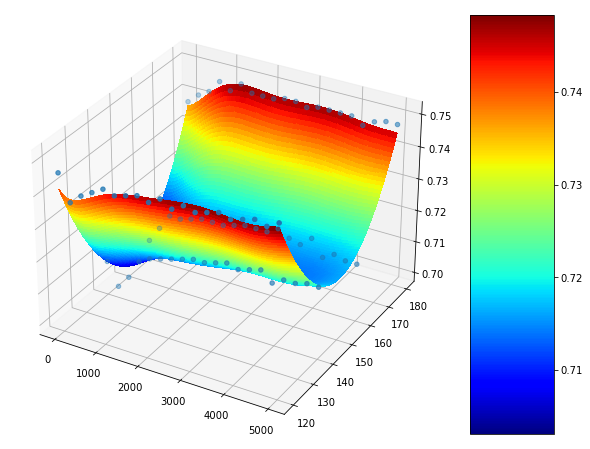

In [6]:
#### Plot
x1 = np.linspace(X[:,0].min(), X[:,0].max(),num = NUM_OF_PLOT_POINTS)
x2 = np.linspace(X[:,1].min(), X[:,1].max(),num = NUM_OF_PLOT_POINTS)
x1x2 = np.array(list(product(x1, x2)))
y_pred, MSE = gp.predict(x1x2, return_std=True)
X0p, X1p = x1x2[:,0].reshape(NUM_OF_PLOT_POINTS,NUM_OF_PLOT_POINTS), x1x2[:,1].reshape(NUM_OF_PLOT_POINTS,NUM_OF_PLOT_POINTS)
Zp = np.reshape(y_pred,(NUM_OF_PLOT_POINTS,NUM_OF_PLOT_POINTS))

x_train = np.linspace(X[:,0].min(), X[:,0].max(),num = NUM_OF_DATA_POINTS)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
pcm = ax.pcolormesh(X0p, X1p, Zp)
fig.colorbar(pcm, ax=ax)
plt.show()

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')            
surf = ax.plot_surface(X0p, X1p, Zp, rstride=1, cstride=1, cmap='jet', linewidth=0, antialiased=False)
ax.scatter(X[:,0],X[:,1],Y)
fig.colorbar(surf, aspect=5)
plt.show()


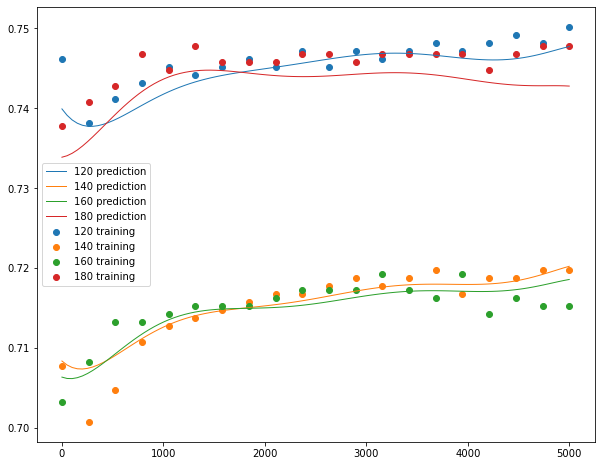

In [7]:
fig = plt.figure(figsize=(10,8))
i = 1
for temp in temp_list:
    plt.plot(x1,Zp[:,i],label = str(temp)+' prediction',lw=1)
    i += int(NUM_OF_PLOT_POINTS/3-1)
j = NUM_OF_DATA_POINTS
for temp in temp_list:
    plt.scatter (x_train,Y[j-NUM_OF_DATA_POINTS:j],label = str(temp)+' training')
    j += NUM_OF_DATA_POINTS
plt.legend()
plt.show()

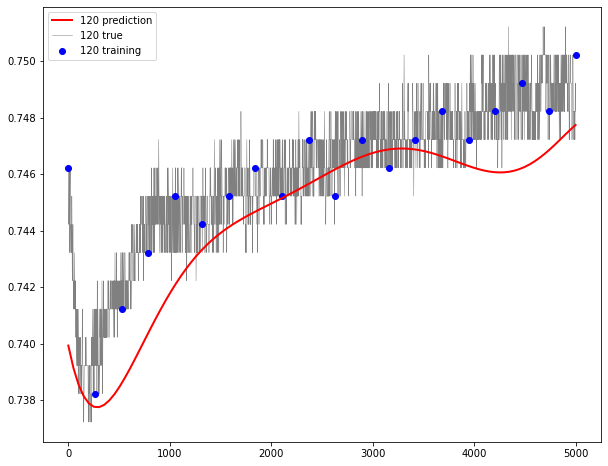

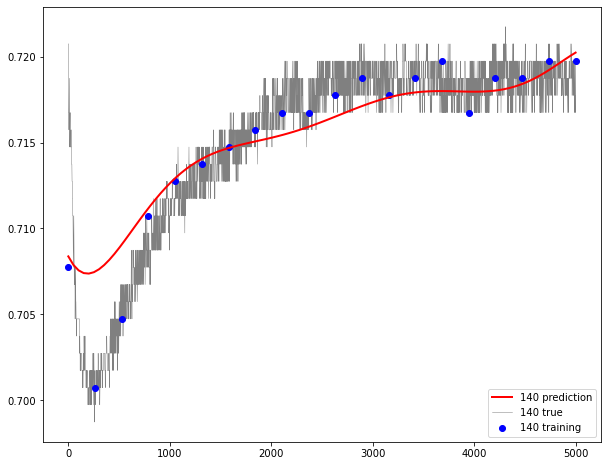

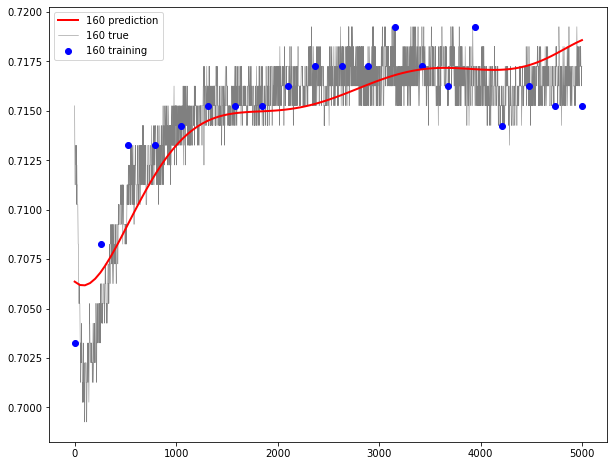

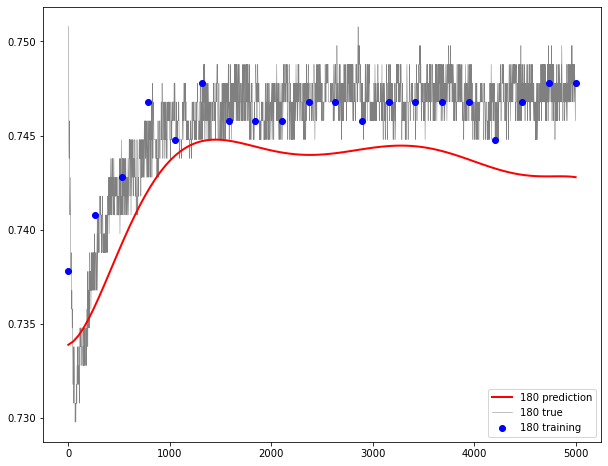

In [8]:
i = 1
j = NUM_OF_DATA_POINTS
k = 0
for temp in temp_list:
    fig = plt.figure(figsize=(10,8))
    plt.plot(x1,Zp[:,i],label = str(temp)+' prediction',c='red',lw=2,zorder=3)
    i += int(NUM_OF_PLOT_POINTS/3-1)
    plt.scatter (x_train,Y[j-NUM_OF_DATA_POINTS:j],label = str(temp)+' training',c='blue',zorder=2)
    j += NUM_OF_DATA_POINTS
    plt.plot(X_,y_normal[k:k+5000],label = str(temp)+' true',lw=0.5,c='grey',zorder=1)
    k+=5000
    plt.legend()
    plt.show()